In [1]:
import pandas as pd
import numpy as np
import os

import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree, naive_bayes
import numpy as np
import seaborn as sns
import re
from scipy.stats import chi2_contingency
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder, StandardScaler
import graphviz
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, balanced_accuracy_score
import optuna
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
import spacy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import pandas as pd
from torch import nn
from torch.nn import functional as F
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import wandb
from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

C:\Users\Bryan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#Random seed
torch.manual_seed(42)
if torch.cuda.is_available():
    print("Cuda is available")
    torch.cuda.manual_seed_all(42)  # For all GPUs

In [2]:
import gc
torch.cuda.empty_cache()
gc.collect()

128

# Wandb login

In [4]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Bryan/.netrc


True

# acllmdb Dataset

## Convert to CSV

In [3]:
def unison_shuffled_copies(a, b, c, random_state=42):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    assert len(a) == len(b)
    assert len(a) == len(c)
    p = np.random.RandomState(seed=random_state).permutation(len(a))
    return a[p], b[p], c[p]

def read_contents_update_array(Dirname, filename, textArray, decimalLabelArray, integerLabelArray):
    originalLabel = filename.split("_")[1].split(".")[0]
    normalizedLabel = (int(originalLabel) - 1) / 9
    decimalLabelArray.append(normalizedLabel)
    integerLabelArray.append(round(normalizedLabel))
    
    with open(Dirname + filename, 'r', encoding='latin-1') as f:
        textArray.append(f.read())

    return textArray, decimalLabelArray, integerLabelArray

In [4]:
# group the supervised into train and test csv
# rating is 1 - 10
# for better scale, we normalize the data to between 0 - 1
textArray = []
decimalLabelArray = []
integerLabelArray = []
motherDir = "./aclImdb/"
for filename in os.listdir(motherDir + "train/pos"):
    textArray, decimalLabelArray, integerLabelArray = read_contents_update_array(motherDir + "train/pos/", filename, textArray, decimalLabelArray, integerLabelArray)
print("Reach here")
for filename in os.listdir(motherDir + "train/neg"):
    textArray, decimalLabelArray, integerLabelArray = read_contents_update_array(motherDir + "train/neg/", filename, textArray, decimalLabelArray, integerLabelArray)

textArray, decimalLabelArray, integerLabelArray = unison_shuffled_copies(textArray, decimalLabelArray, integerLabelArray)

KeyboardInterrupt: 

In [ ]:
train_df = pd.DataFrame({'text': textArray, 'decimalLabel': decimalLabelArray, 'integerLabel': integerLabelArray})
train_df.to_csv("aclimdb/train.csv", index=False)

In [24]:
# group the supervised into train and test csv
# rating is 1 - 10
# for better scale, we normalize the data to between 0 - 1
textArray = []
decimalLabelArray = []
integerLabelArray = []
motherDir = "./aclImdb/"
for filename in os.listdir(motherDir + "test/pos"):
    textArray, decimalLabelArray, integerLabelArray = read_contents_update_array(motherDir + "test/pos/", filename, textArray, decimalLabelArray, integerLabelArray)
print("Reach here")
for filename in os.listdir(motherDir + "test/neg"):
    textArray, decimalLabelArray, integerLabelArray = read_contents_update_array(motherDir + "test/neg/", filename, textArray, decimalLabelArray, integerLabelArray)

textArray, decimalLabelArray, integerLabelArray = unison_shuffled_copies(textArray, decimalLabelArray, integerLabelArray)

Reach here


In [26]:
test_df = pd.DataFrame({'text': textArray, 'decimalLabel': decimalLabelArray, 'integerLabel': integerLabelArray})
test_df.to_csv("aclimdb/test.csv", index=False)

## Read CSV, create heuristic characteristic for analysis

In [4]:
train_acl = pd.read_csv("aclimdb/train.csv")
test_acl = pd.read_csv("aclimdb/test.csv")

In [5]:
#Try to extract several variables from text
#simple features
def splitSentenceInPredefinedSeparator(x):
    separators = [',', ' ', '.' , ';', ':', '!', '?', '"', "'", "<br />"]
    for separator in separators:
        x = x.replace(separator, ' ')
    return str(x).split()

#Count number of words
def numberOfWords(x):
    #return number of words that has been splitted including with ',', '.', ' '
    return len(splitSentenceInPredefinedSeparator(x))

def uniqueWords(x):
    #return number of unique words that has been splitted including with ',', '.', ' '
    return len(set(splitSentenceInPredefinedSeparator(x)))


train_acl['num-words'] = train_acl['text'].apply(lambda x: numberOfWords(x))
test_acl['num-words'] = test_acl['text'].apply(lambda x: numberOfWords(x))
#Count number of unique words
train_acl['num-unique-words'] = train_acl['text'].apply(lambda x: uniqueWords(x))
test_acl['num-unique-words'] = test_acl['text'].apply(lambda x: uniqueWords(x))
#Count number of punctuations
train_acl['num-punctuations'] = train_acl['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_acl['num-punctuations'] = test_acl['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#UniqueWordRatio
train_acl['unique-word-ratio'] = train_acl['num-unique-words'] / train_acl['num-words']
test_acl['unique-word-ratio'] = test_acl['num-unique-words'] / test_acl['num-words']
#PunctuationRatio
train_acl['punctuation-ratio'] = train_acl['num-punctuations'] / train_acl['num-words']
test_acl['punctuation-ratio'] = test_acl['num-punctuations'] / test_acl['num-words']
#Sentence Length
train_acl['sentence-length'] = train_acl['text'].apply(lambda x: len(x.split('.')))
test_acl['sentence-length'] = test_acl['text'].apply(lambda x: len(x.split('.')))
#Number of Words beginning with capital letters (Other than first word in a sentence after period)
train_acl['num-words-beginning-capital'] = train_acl['text'].apply(lambda x: len([w for w in x.split() if w[0].isupper() and w[0] not in ['.', '"', "'"]]))
test_acl['num-words-beginning-capital'] = test_acl['text'].apply(lambda x: len([w for w in x.split() if w[0].isupper() and w[0] not in ['.', '"', "'"]]))
# #Count Number of Nouns, and Nouns Ratio
# print("beginning noun extraction")
# train_acl['num-nouns'] = train_acl['text'].apply(lambda x: len([w for w in word_tokenize(x) if pos_tag([w])[0][1] in ['NN', 'NNP']]))
# test_acl['num-nouns'] = test_acl['text'].apply(lambda x: len([w for w in word_tokenize(x) if pos_tag([w])[0][1] in ['NN', 'NNP']]))
# train_acl['nouns-ratio'] = train_acl['num-nouns'] / train_acl['num-words']
# test_acl['nouns-ratio'] = test_acl['num-nouns'] / test_acl['num-words']
# #Count Number of Verbs, and Verbs Ratio
# print("beginning verb extraction")
# train_acl['num-verbs'] = train_acl['text'].apply(lambda x: len([w for w in word_tokenize(x) if pos_tag([w])[0][1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]))
# test_acl['num-verbs'] = test_acl['text'].apply(lambda x: len([w for w in word_tokenize(x) if pos_tag([w])[0][1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]))
# train_acl['verbs-ratio'] = train_acl['num-verbs'] / train_acl['num-words']
# test_acl['verbs-ratio'] = test_acl['num-verbs'] / test_acl['num-words']
# #Count Number of Adjectives, and Adjectives Ratio
# print("beginning adjective extraction")
# train_acl['num-adjectives'] = train_acl['text'].apply(lambda x: len([w for w in word_tokenize(x) if pos_tag([w])[0][1] in ['JJ', 'JJR', 'JJS']]))
# test_acl['num-adjectives'] = test_acl['text'].apply(lambda x: len([w for w in word_tokenize(x) if pos_tag([w])[0][1] in ['JJ', 'JJR', 'JJS']]))
# train_acl['adjectives-ratio'] = train_acl['num-adjectives'] / train_acl['num-words']
# test_acl['adjectives-ratio'] = test_acl['num-adjectives'] / test_acl['num-words']
# #Average Word Length
# train_acl['average-word-length'] = train_acl['text'].apply(lambda x: np.mean([len(w) for w in splitSentenceInPredefinedSeparator(x)]))
# test_acl['average-word-length'] = test_acl['text'].apply(lambda x: np.mean([len(w) for w in splitSentenceInPredefinedSeparator(x)]))
# #stopwords count
# train_acl['stopwords-count'] = train_acl['text'].apply(lambda x: len([w for w in splitSentenceInPredefinedSeparator(x) if w.lower() in nltk.corpus.stopwords.words('english')]))
# test_acl['stopwords-count'] = test_acl['text'].apply(lambda x: len([w for w in splitSentenceInPredefinedSeparator(x) if w.lower() in nltk.corpus.stopwords.words('english')]))
# train_acl['Stopwords-ratio'] = train_acl['stopwords-count'] / test_acl['num-words']
# test_acl['Stopwords-ratio'] = test_acl['stopwords-count'] / test_acl['num-words']

In [6]:
#Noun extraction
print("beginning verb extraction")
train_num_verbs = []
test_num_verbs = []
for i in range(len(train_acl)):
    if i % 100 == 0:
        print(i)
    train_num_verbs.append(len([w for w in word_tokenize(train_acl['text'][i]) if pos_tag([w])[0][1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]))
    test_num_verbs.append(len([w for w in word_tokenize(test_acl['text'][i]) if pos_tag([w])[0][1] in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']]))
train_acl['num-verbs'] = train_num_verbs
test_acl['num-verbs'] = test_num_verbs

beginning noun extraction
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000


In [7]:
train_acl.head()

,text,decimalLabel,integerLabel,num-words,num-unique-words,num-punctuations,unique-word-ratio,punctuation-ratio,sentence-length,num-words-beginning-capital,num-nouns
0,In Panic In The Streets Richard Widmark plays ...,0.777778,1,466,258,78,0.553648,0.167382,27,94,57
1,If you ask me the first one was really better ...,0.000000,0,137,82,33,0.598540,0.240876,13,19,22
2,I am a big fan a Faerie Tale Theatre and I've ...,1.000000,1,146,81,22,0.554795,0.150685,11,24,15
3,I just finished reading a book about Dillinger...,0.000000,0,168,107,25,0.636905,0.148810,14,25,24
4,Greg Davis and Bryan Daly take some crazed sta...,0.111111,0,143,99,17,0.692308,0.118881,5,23,8


In [13]:
train_acl = train_acl.rename(columns={'num-nouns': 'num-verbs'})
test_acl = test_acl.rename(columns={'num-nouns': 'num-verbs'})

In [14]:
train_acl.head()

,text,decimalLabel,integerLabel,num-words,num-unique-words,num-punctuations,unique-word-ratio,punctuation-ratio,sentence-length,num-words-beginning-capital,num-verbs
0,In Panic In The Streets Richard Widmark plays ...,0.777778,1,466,258,78,0.553648,0.167382,27,94,57
1,If you ask me the first one was really better ...,0.000000,0,137,82,33,0.598540,0.240876,13,19,22
2,I am a big fan a Faerie Tale Theatre and I've ...,1.000000,1,146,81,22,0.554795,0.150685,11,24,15
3,I just finished reading a book about Dillinger...,0.000000,0,168,107,25,0.636905,0.148810,14,25,24
4,Greg Davis and Bryan Daly take some crazed sta...,0.111111,0,143,99,17,0.692308,0.118881,5,23,8


In [15]:
train_acl['verbs-ratio'] = train_acl['num-verbs'] / train_acl['num-words']
test_acl['verbs-ratio'] = test_acl['num-verbs'] / test_acl['num-words']

In [16]:
train_acl.to_csv("aclimdb/train_heuristic_verbs.csv", index=False)
test_acl.to_csv("aclimdb/test_heuristic_verbs.csv", index=False)

## Gather adjectives, and nouns counting result that is run on the other ipynb

In [18]:
train_acl_nouns = pd.read_csv("aclimdb/train_heuristic_nouns.csv")
test_acl_nouns = pd.read_csv("aclimdb/train_heuristic_nouns.csv")
train_acl_adjs = pd.read_csv("aclimdb/train_heuristic_adjs.csv")
test_acl_adjs = pd.read_csv("aclimdb/train_heuristic_adjs.csv")

In [19]:
train_acl["num-nouns"] = train_acl_nouns["num-nouns"]
test_acl["num-nouns"] = test_acl_nouns["num-nouns"]
train_acl["nouns-ratio"] = train_acl_nouns["nouns-ratio"]
test_acl["nouns-ratio"] = test_acl_nouns["nouns-ratio"]
train_acl["num-adjs"] = train_acl_adjs["num-adjs"]
test_acl["num-adjs"] = test_acl_adjs["num-adjs"]
train_acl["adjs-ratio"] = train_acl_adjs["adjs-ratio"]
test_acl["adjs-ratio"] = test_acl_adjs["adjs-ratio"]

In [22]:
train_acl['average-word-length'] = train_acl['text'].apply(lambda x: np.mean([len(w) for w in splitSentenceInPredefinedSeparator(x)]))
test_acl['average-word-length'] = test_acl['text'].apply(lambda x: np.mean([len(w) for w in splitSentenceInPredefinedSeparator(x)]))

KeyboardInterrupt: 

In [23]:
print("beginning stopwords extraction")
train_num_stopwords = []
test_num_stopwords = []
for i in range(len(train_acl)):
    if i % 100 == 0:
        print(i)
    train_num_stopwords.append(len([w for w in splitSentenceInPredefinedSeparator(train_acl["text"][i]) if w.lower() in nltk.corpus.stopwords.words('english')]))
    test_num_stopwords.append(len([w for w in splitSentenceInPredefinedSeparator(test_acl["text"][i]) if w.lower() in nltk.corpus.stopwords.words('english')]))

beginning stopwords extraction
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
1

KeyError: 'stopwords-count'

In [24]:
train_acl['stopwords-count'] = train_num_stopwords
test_acl['stopwords-count'] = test_num_stopwords
train_acl['stopwords-ratio'] = train_acl['stopwords-count'] / test_acl['num-words']
test_acl['stopwords-ratio'] = test_acl['stopwords-count'] / test_acl['num-words']

In [33]:
#make a new string column that maps integerLabel = 1 as "positive" and integerLabel = 0 as "negative"
train_acl['sentiment'] = train_acl['integerLabel'].map({1: "positive", 0: "negative"})

In [34]:
train_acl.to_csv("aclimdb/train_heuristic.csv", index=False)
test_acl.to_csv("aclimdb/test_heuristic.csv", index=False)

## EDA on heuristic features

In [35]:
categorical_amount = 0
continuous_amount = 0
for column, dtype in train_acl.dtypes.items():
    group = 'continuous' if dtype in ['int64', 'float64'] else 'categorical'
    if(group == 'categorical'):
        categorical_amount += 1
    else:
        continuous_amount += 1
    print(f"Column {column} has data type {dtype}/{group}")
print(f"Total categorical columns: {categorical_amount}")
print(f"Total continuous columns: {continuous_amount}")

Column text has data type object/categorical
Column decimalLabel has data type float64/continuous
Column integerLabel has data type int64/continuous
Column num-words has data type int64/continuous
Column num-unique-words has data type int64/continuous
Column num-punctuations has data type int64/continuous
Column unique-word-ratio has data type float64/continuous
Column punctuation-ratio has data type float64/continuous
Column sentence-length has data type int64/continuous
Column num-words-beginning-capital has data type int64/continuous
Column num-verbs has data type int64/continuous
Column verbs-ratio has data type float64/continuous
Column num-nouns has data type int64/continuous
Column nouns-ratio has data type float64/continuous
Column num-adjs has data type int64/continuous
Column adjs-ratio has data type float64/continuous
Column average-word-length has data type float64/continuous
Column stopwords-count has data type int64/continuous
Column stopwords-ratio has data type float64/

In [36]:
#function for visualization
def describe_continuous_dataset(dataframe, column, target='sentiment'):
    #use violin plot to see the distribution of the data
    # Define figure size.
    plt.figure(figsize=(20, 7))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(dataframe[column], kde = True,color='r')
    plt.title('Histogram (Distribution)')

    plt.subplot(1, 3, 2)
    sns.violinplot(data=dataframe, x=column, y=target)
    plt.title('violinplot (Distribution respect to target)')
    
    
    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=dataframe[column],color = 'b')
    plt.title('Boxplot (More native approach to see distribution)')
    
    # barplot
    # plt.subplot(1, 4, 5)
    # sns.barplot(x = column, y = target, data = dataframe)   
    # plt.title('Barplot')
    
    
    plt.show()

def describe_target_dataset(dataframe, target):
    plt.figure(figsize=(20, 7))

    sns.countplot(data=dataframe, x=target, order=dataframe[target].value_counts().index)
    plt.title(f'Count of {target}')
    plt.ylabel('Count')

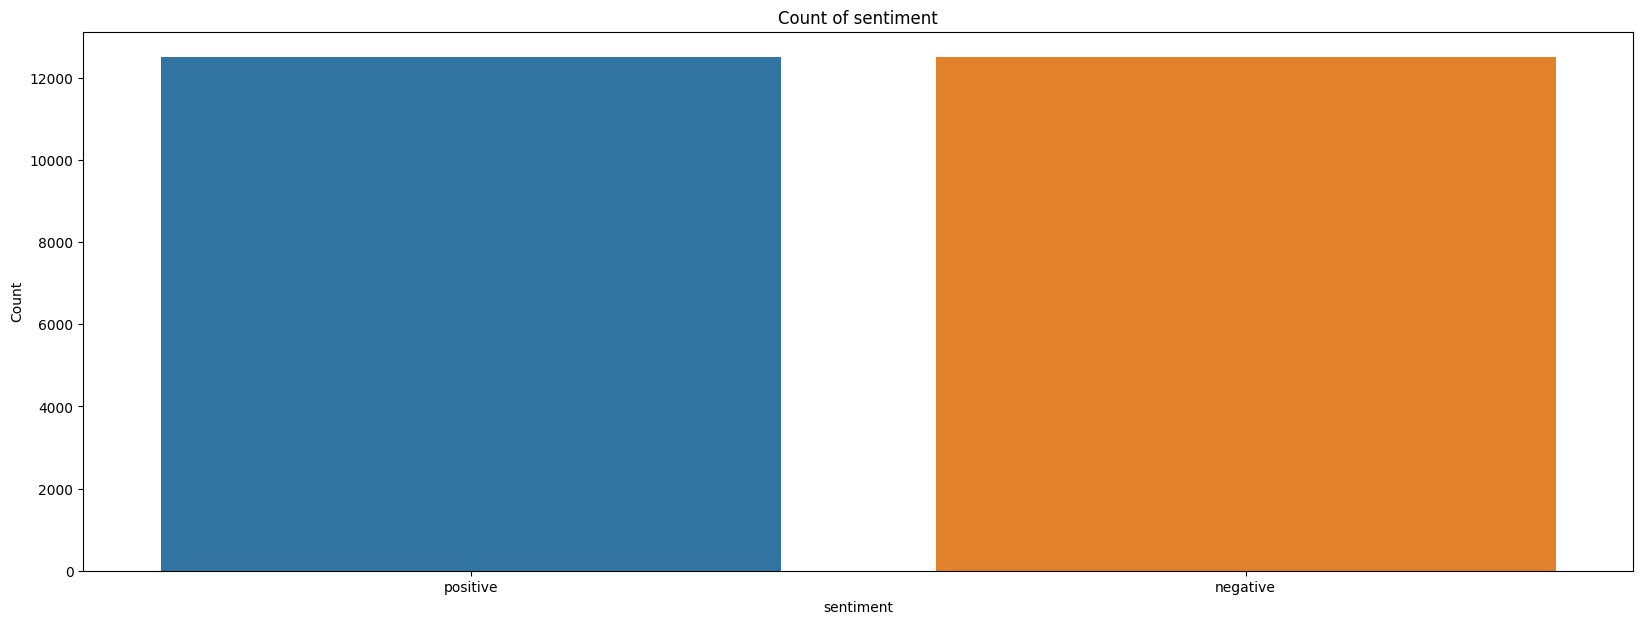

In [38]:
describe_target_dataset(train_acl, "sentiment")

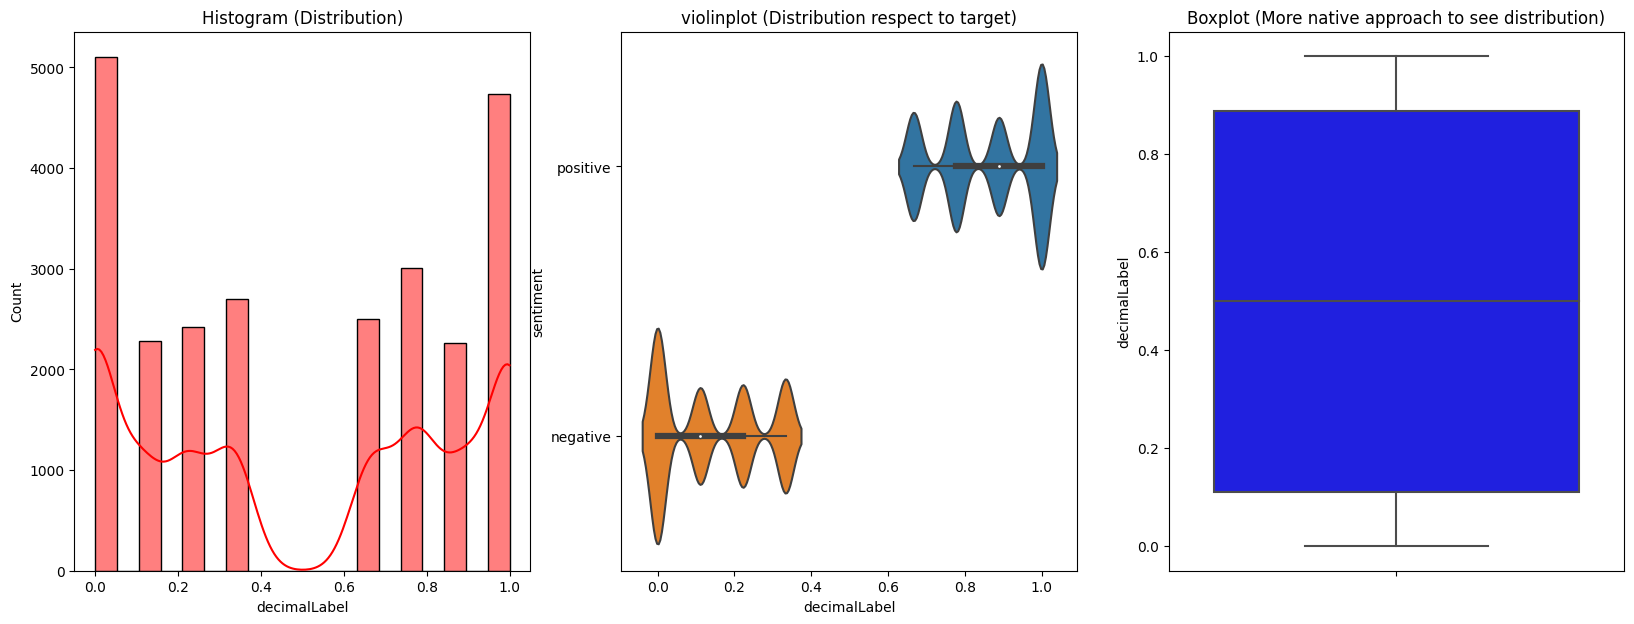

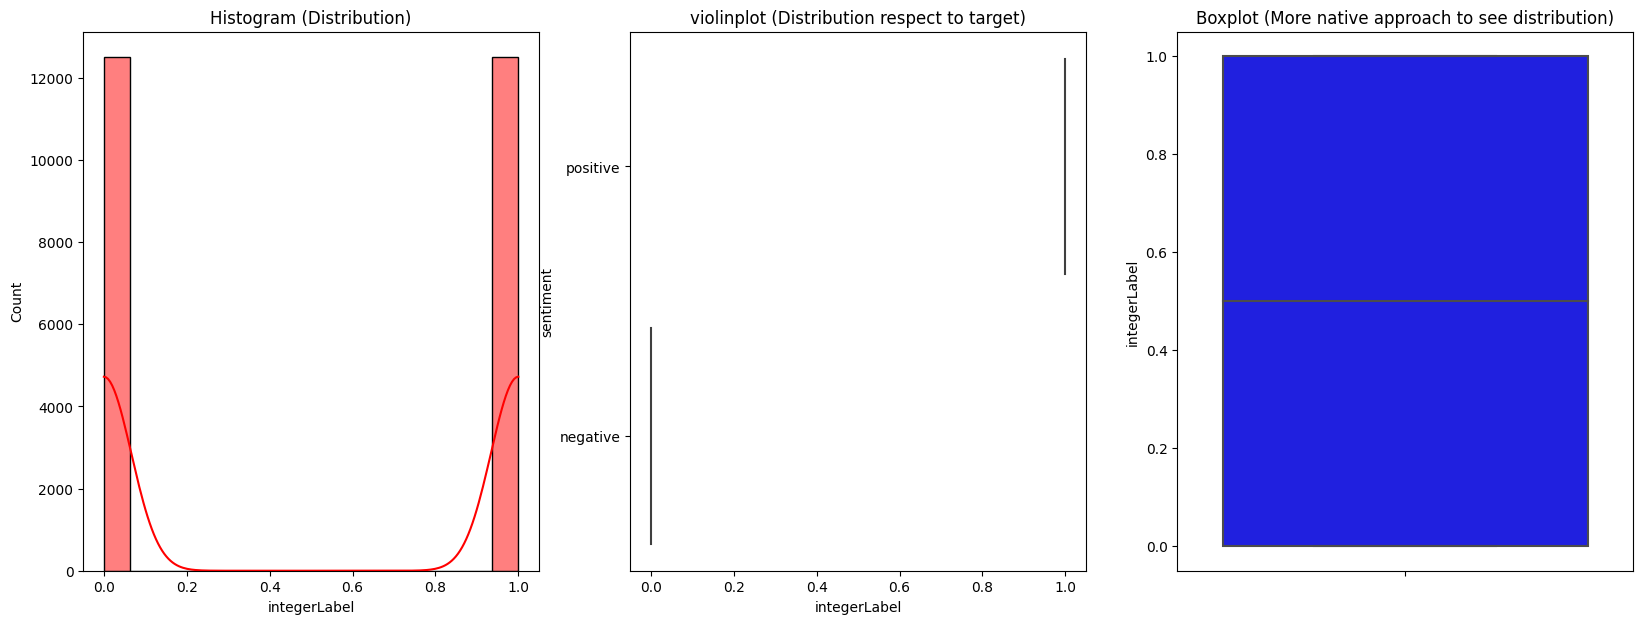

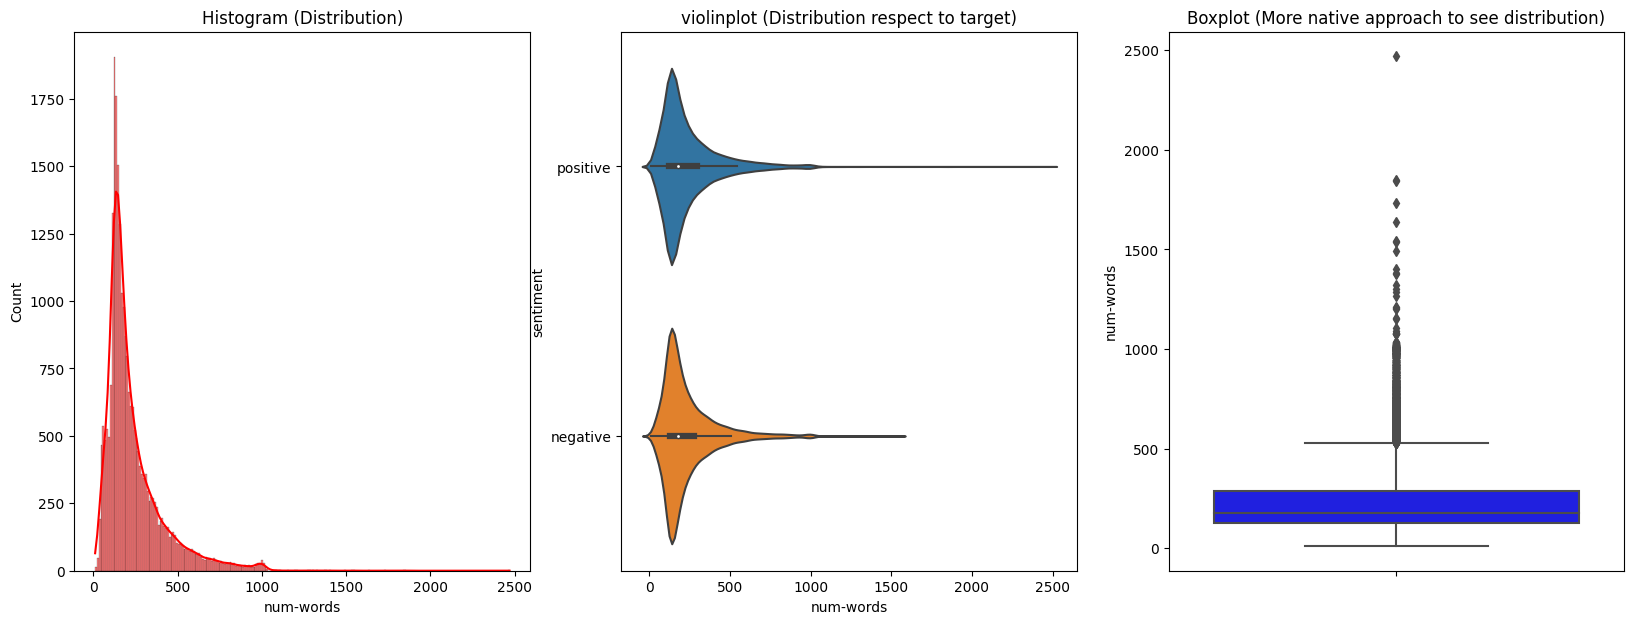

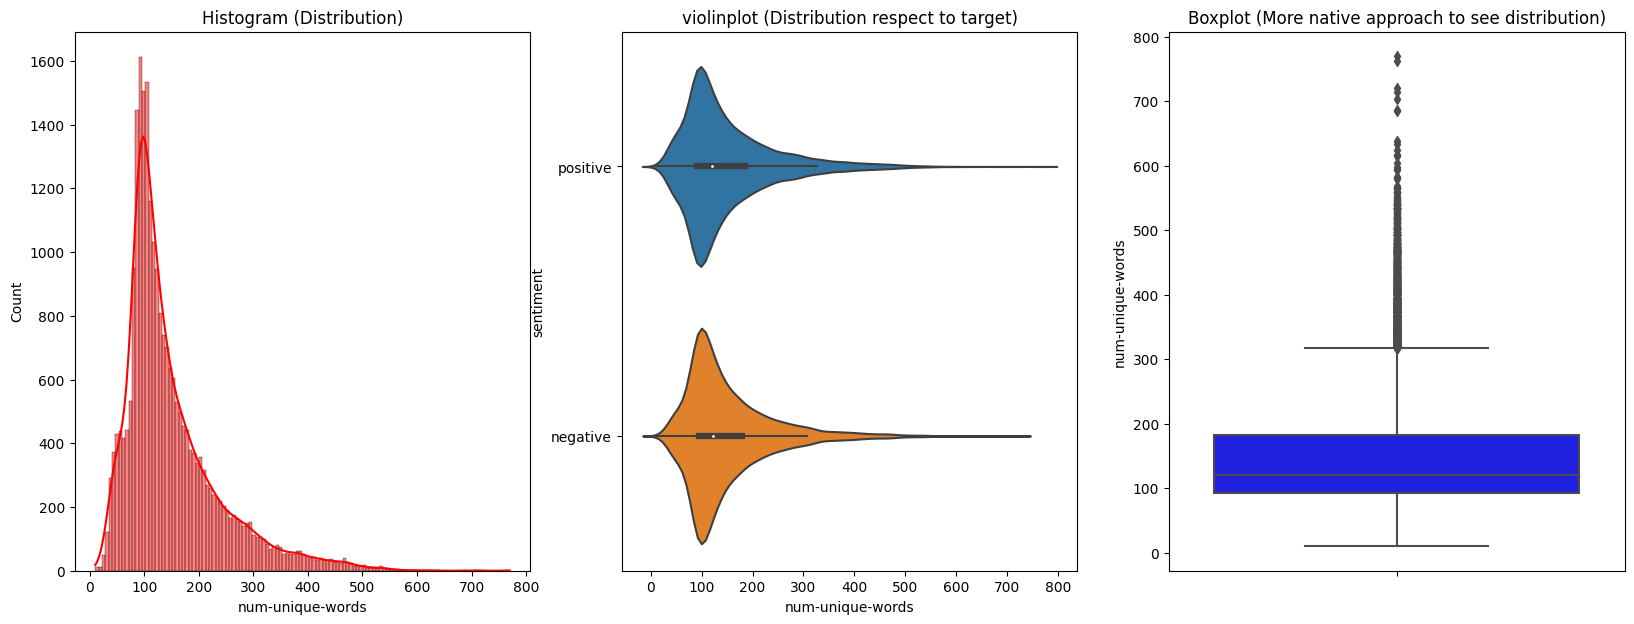

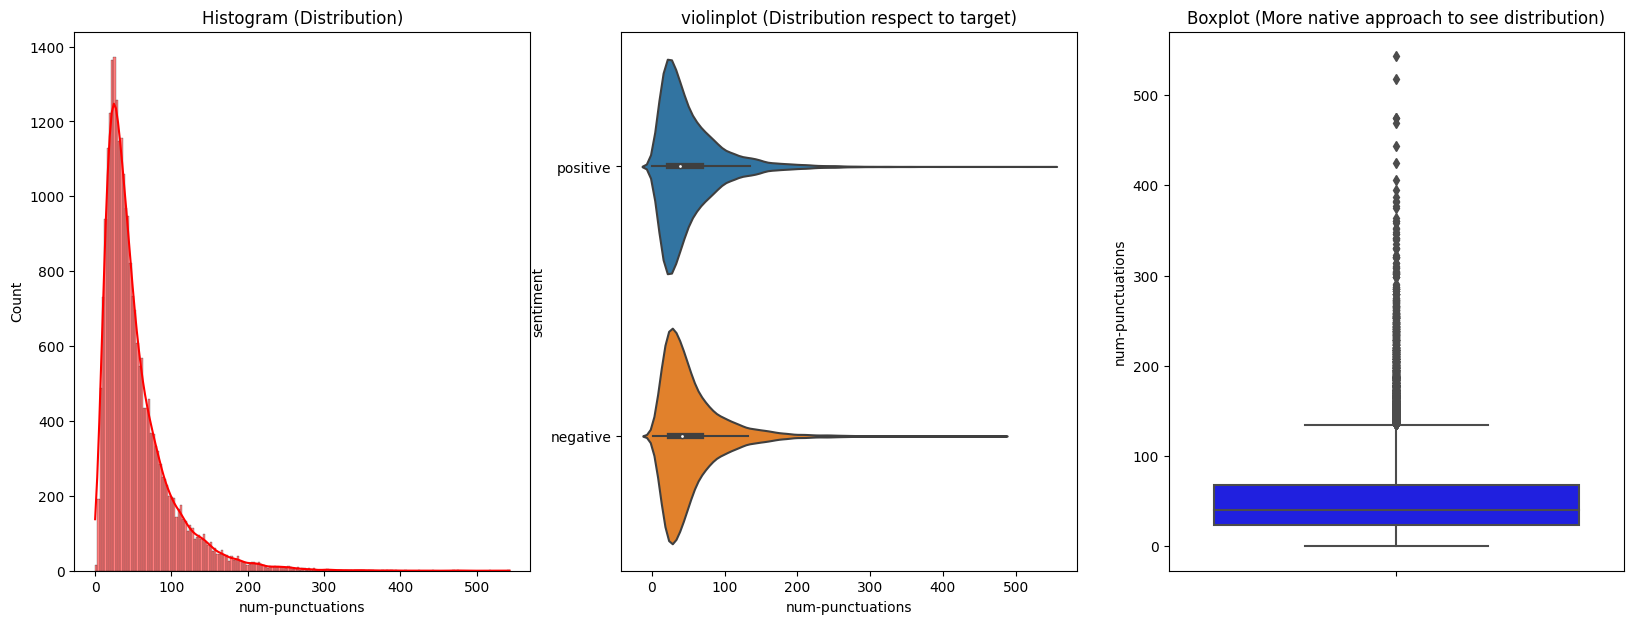

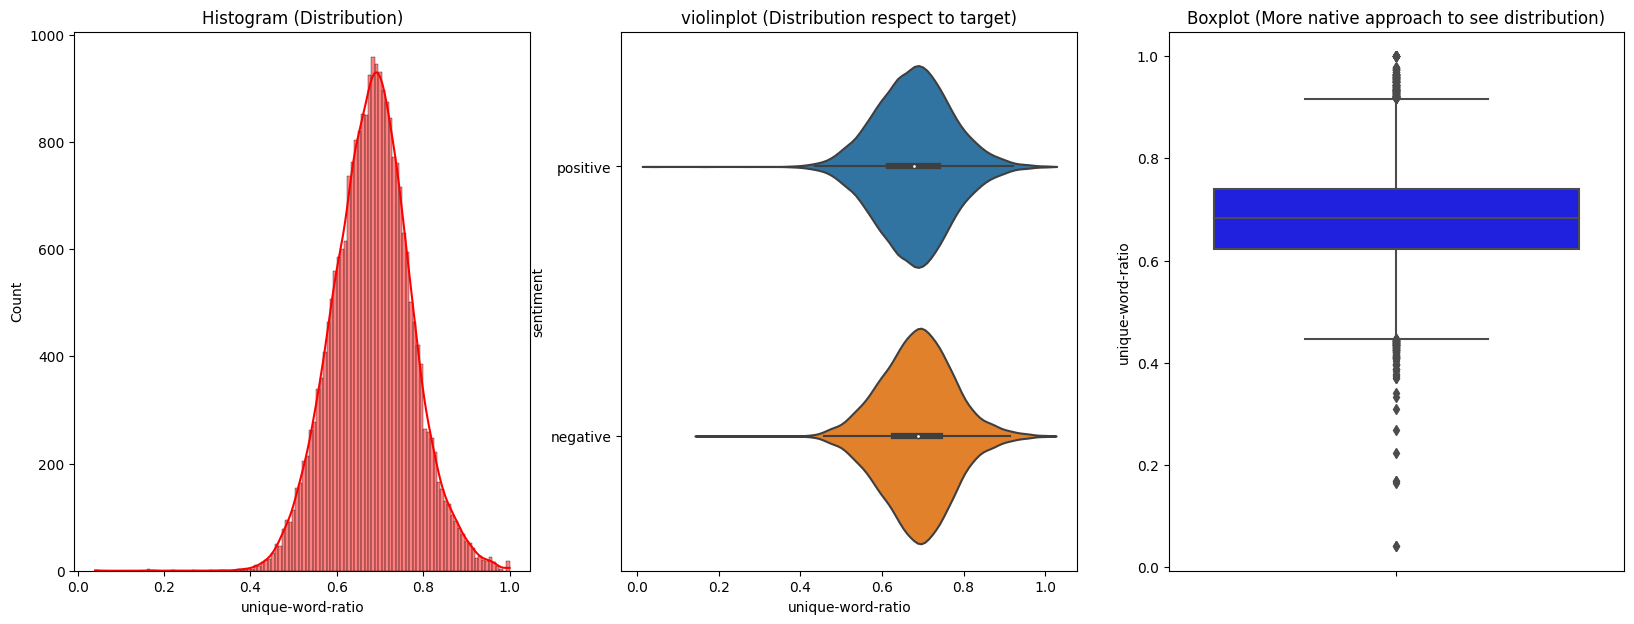

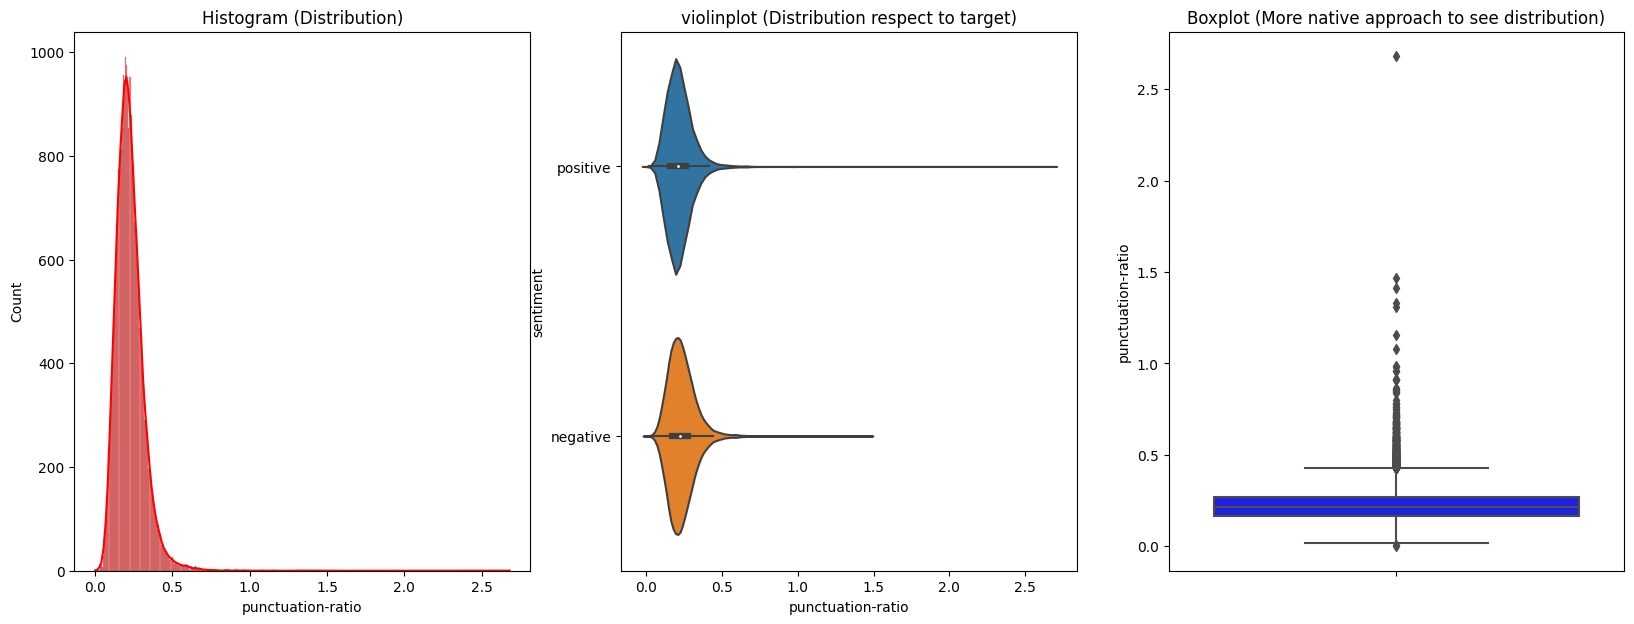

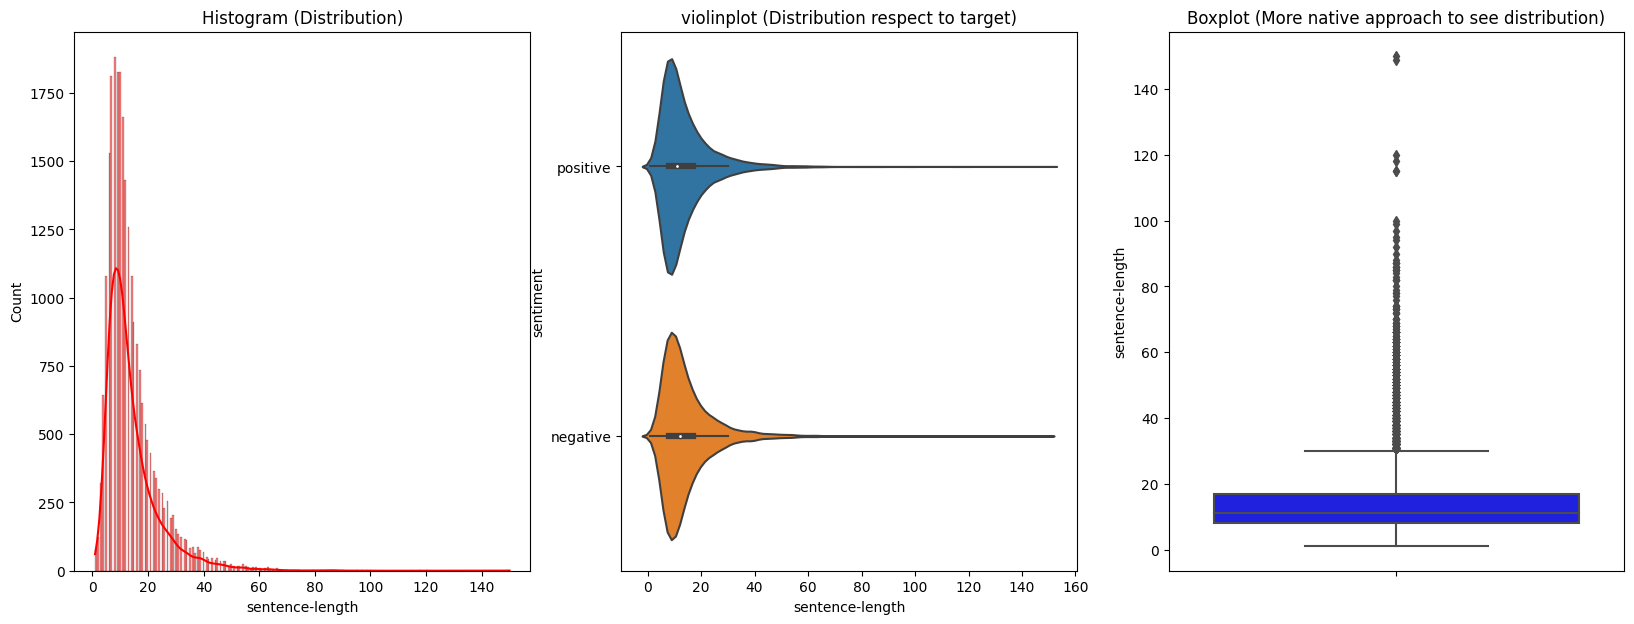

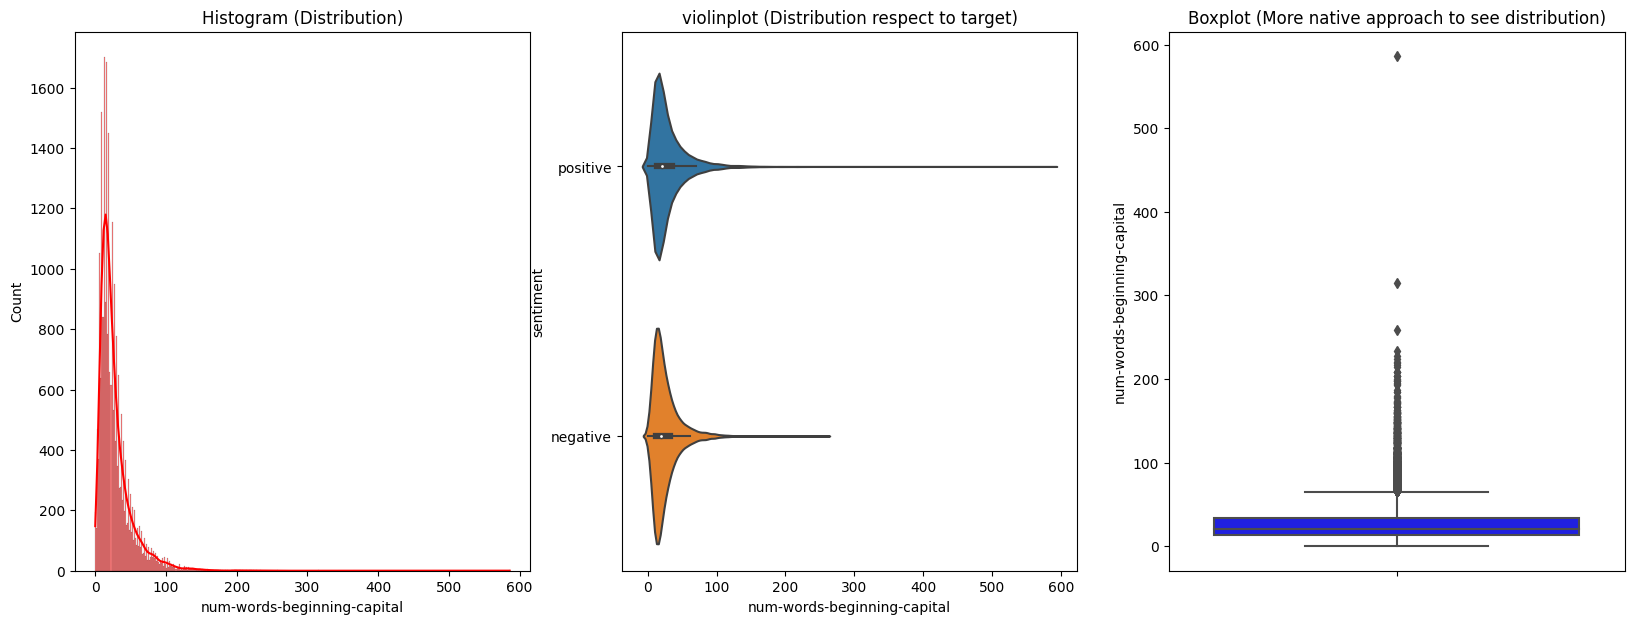

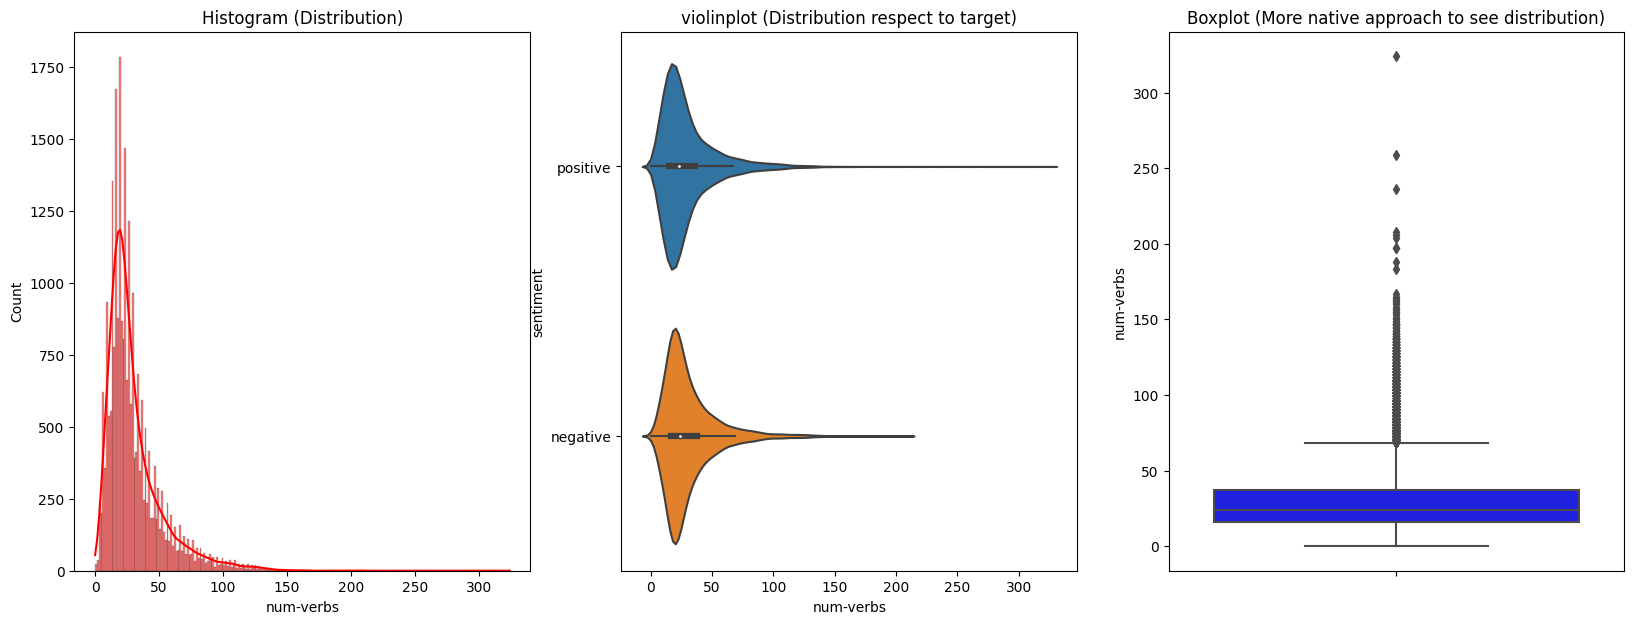

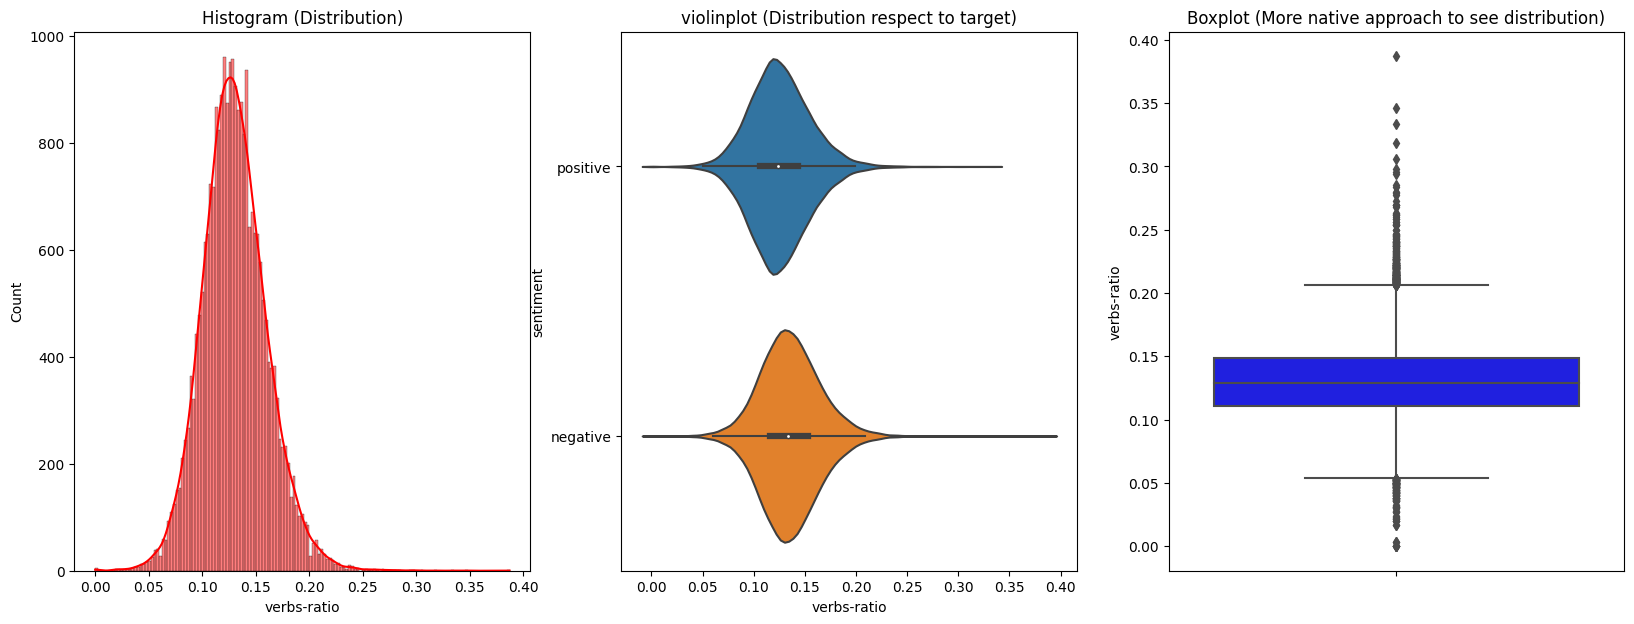

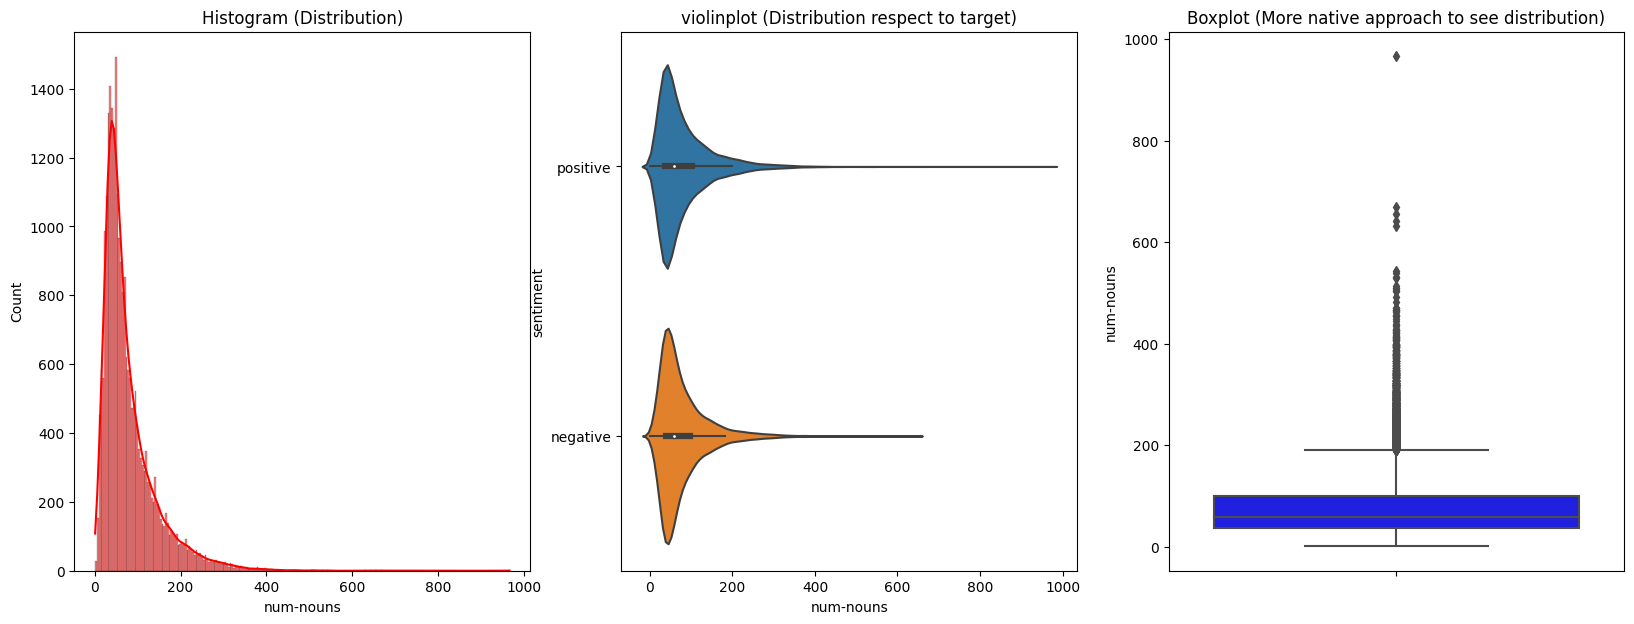

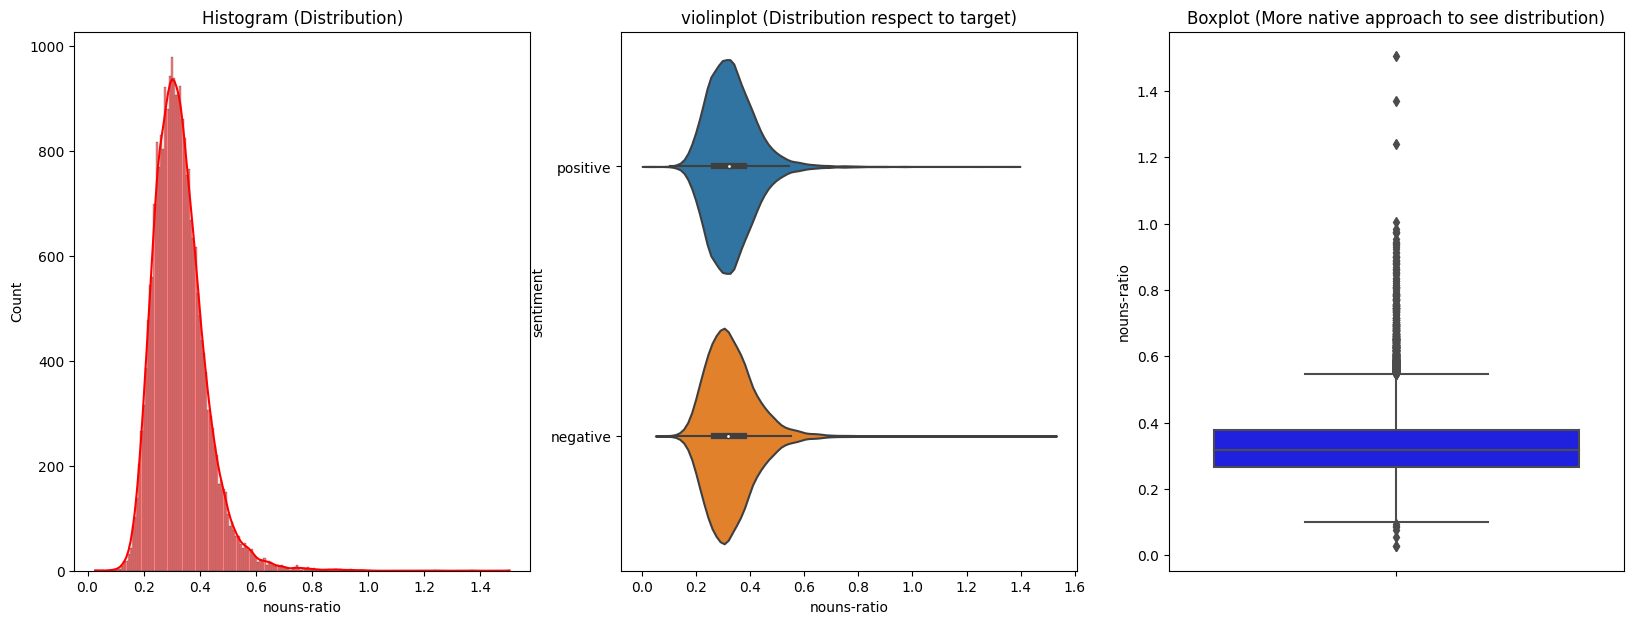

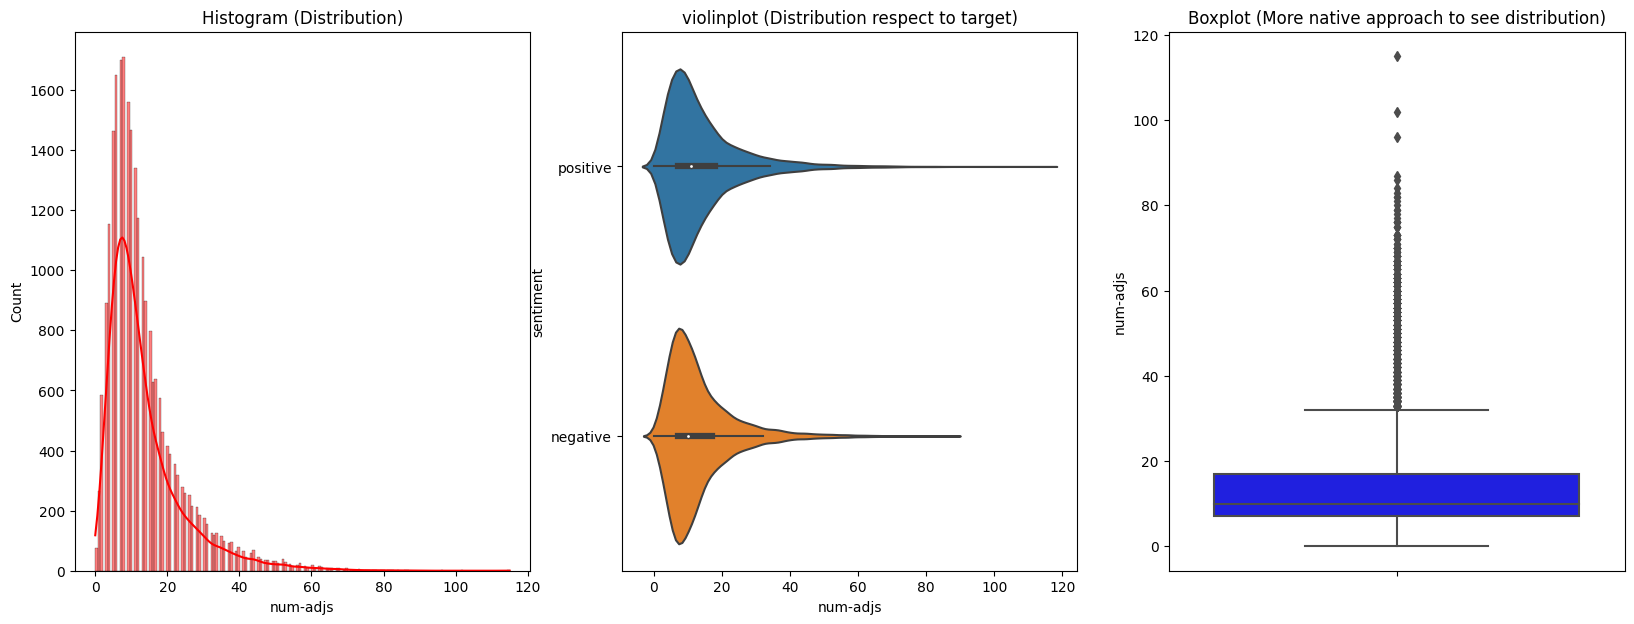

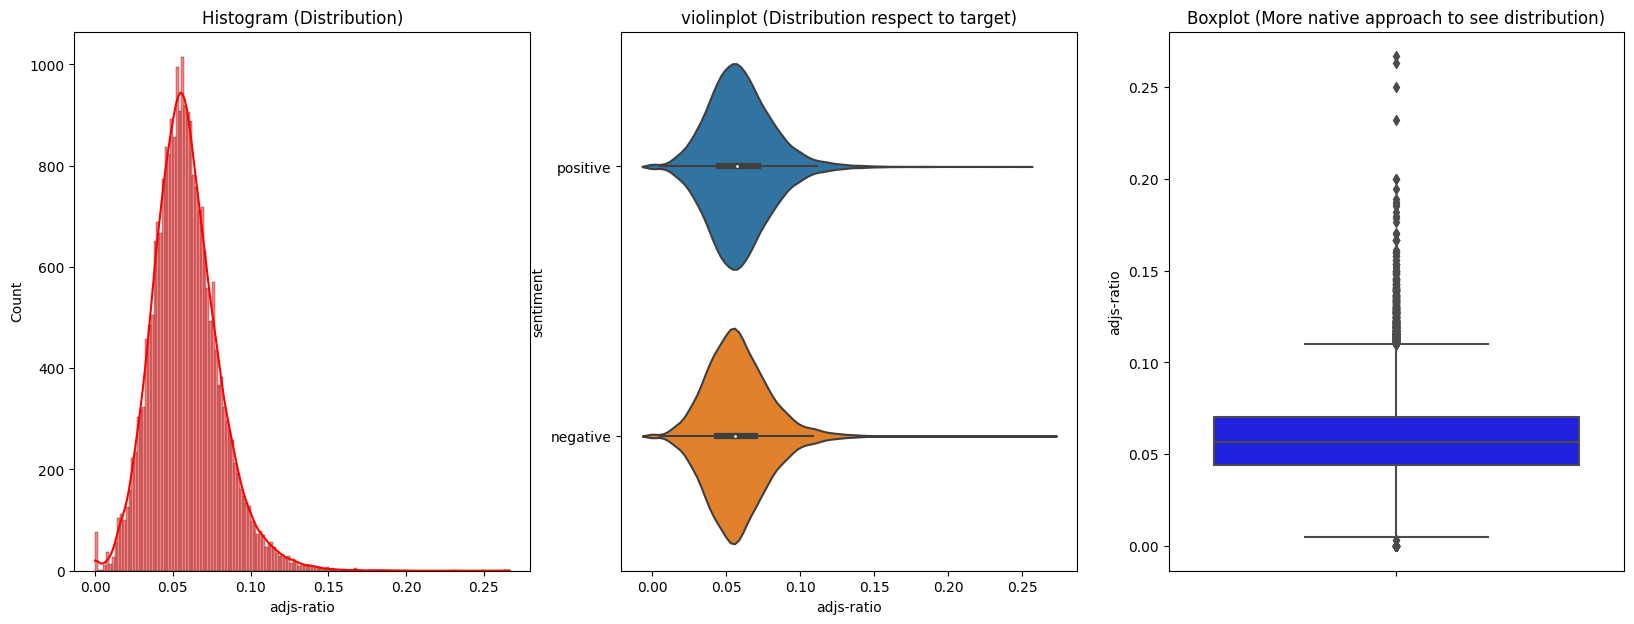

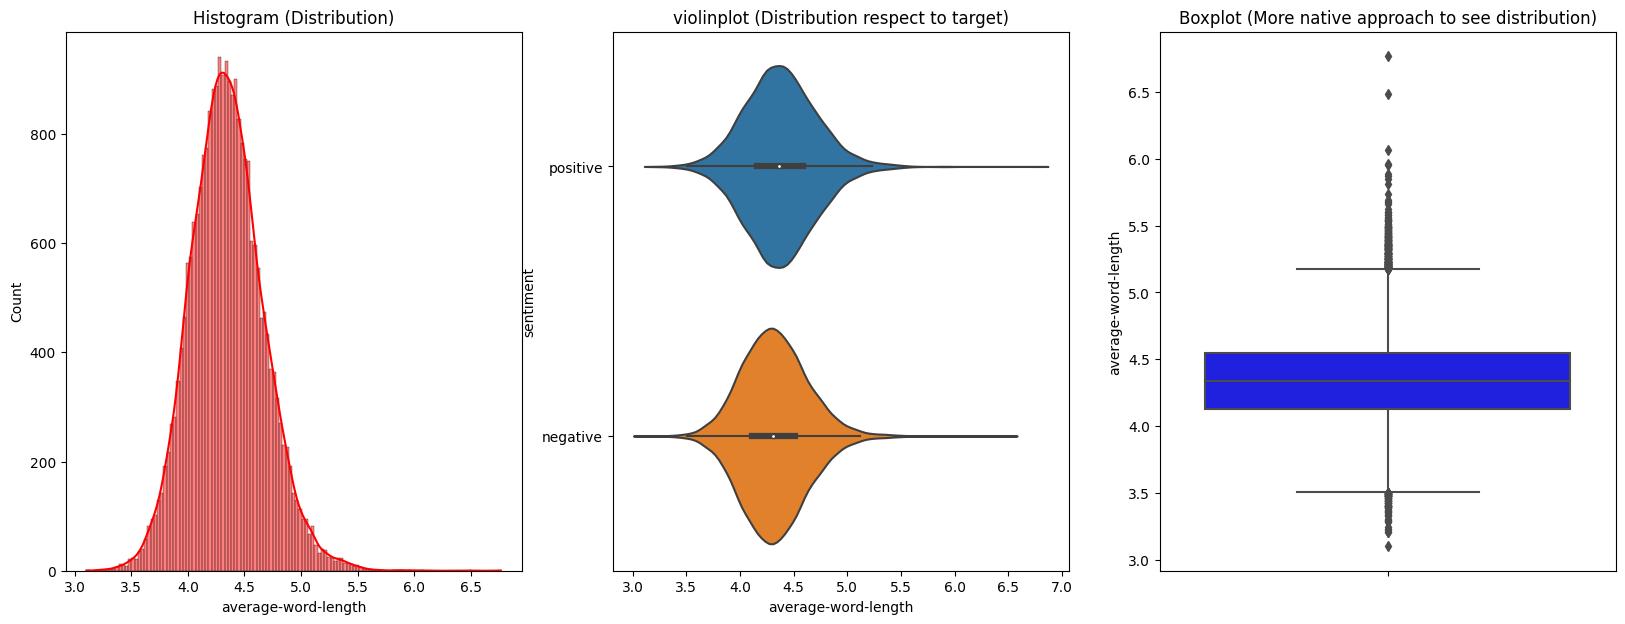

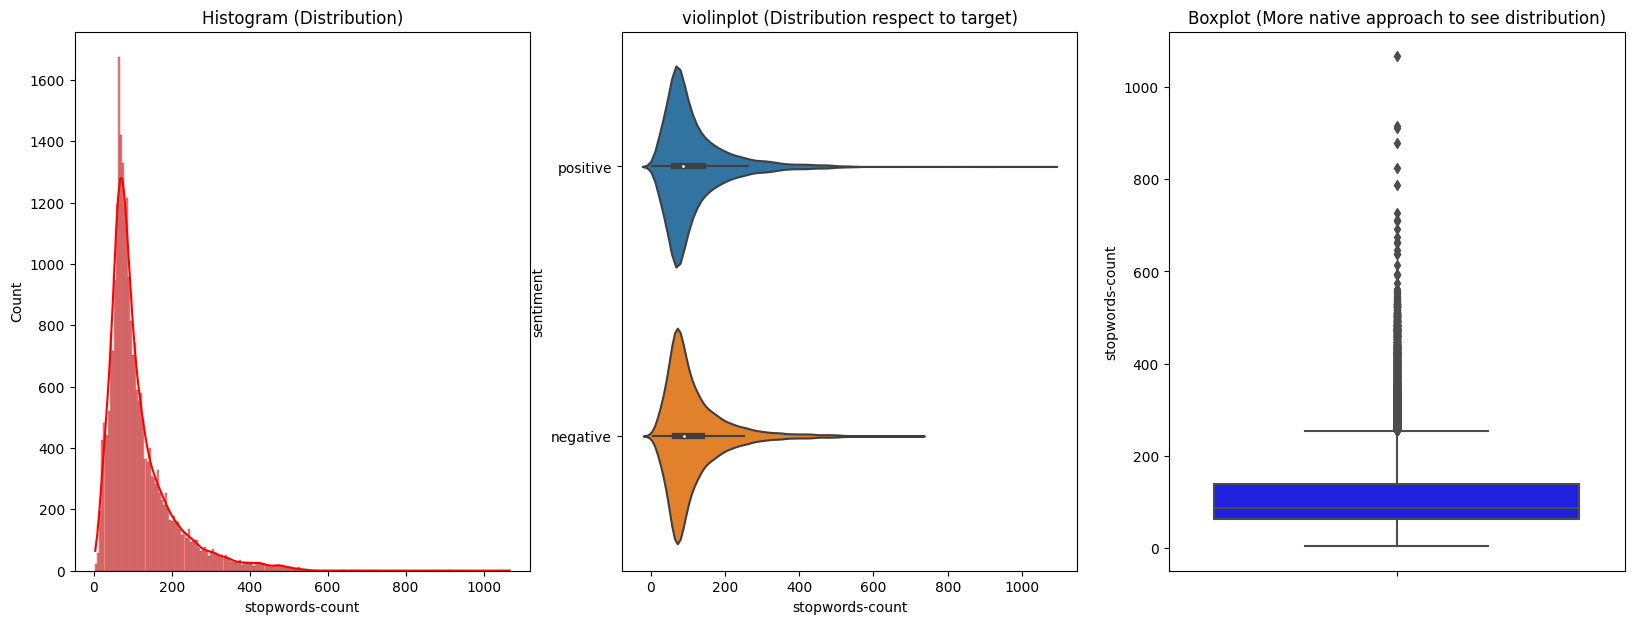

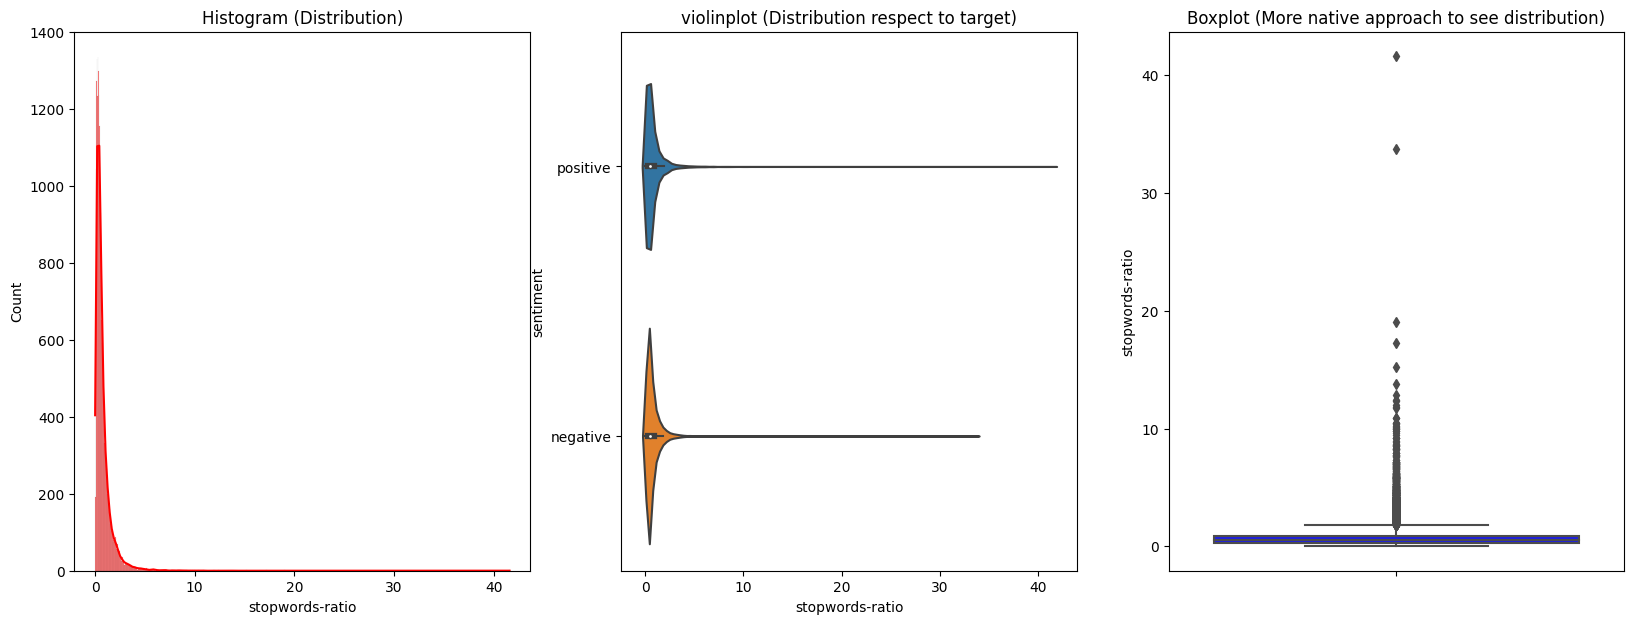

In [39]:
continuous_vars = []
for column, dtype in train_acl.dtypes.items():
    if dtype in ['int64', 'float64']:
        continuous_vars.append(column)
#Evaluate Continuous Columns
for column in continuous_vars:
    describe_continuous_dataset(train_acl, column)

## Load CSV Data

In [5]:
train_acl = pd.read_csv("aclimdb/train_heuristic.csv")
test_acl = pd.read_csv("aclimdb/test_heuristic.csv")

## Feature Engineering: Stemming and Lemmatizaton

### Remove Pattern with @.. which involves email or username

In [ ]:
# fucntion to removes pattern in the input text.

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

imdb['review'] = np.vectorize(remove_pattern)(imdb['review'], "@[\w]*")

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing emojis
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols                                                                         
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

# Text-encoding: UTF-8 encoder
def to_unicode(text):
    if isinstance(text, float):
        text = str(text)
    if isinstance(text, int):
        text = str(text)
    if not isinstance(text, str):
        text = text.decode('utf-8', 'ignore')
    return text

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

# Removing the noisy text
def denoise_text(text):
    text = to_unicode(text)
    text = strip_html(text)
    text = re.sub(r"http\S+", "", text)
    text = deEmojify(text)
    text = text.encode('ascii', 'ignore')
    text = to_unicode(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    text = text.lower() # lower case 
    return text



## Feature Engineering: Bag of Words

## Feature Engineering: TF-IDF

In [16]:
tfidf_transformer = TfidfVectorizer(stop_words = "english")
tfidf_transformer.fit(SpookyTrain['text'])
Train_tfidf = tfidf_transformer.transform(x for x in SpookyTrain['text'])

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700


KeyboardInterrupt: 

## Preparing the Data
As to make learning simpler, I will make it all to two classes only: 0 or 1 for the sentiment analysis

Split the test dataset to:
Eval: 15 000
Test: 10 000

Data that will be prepared: 
1. Normal Text Dataset --> Feed to Transformer model with their predefined tokenizers
2. Heuristic Extracted Dataset --> Feed to Traditional ML Models such as Log Reg
3. Text Dataset, but with stopwords removed

In [6]:
val_acl, final_test_acl = train_test_split(test_acl, test_size=0.4, stratify=test_acl["integerLabel"],random_state=42) #due to we want to have 10 cross vals

## Finetuning Model Quick Pipeline (For Transformer)

In [12]:
class QuickSentimentAnalysisFinetuningModel:
    def __init__(self, model_name, learning_rate, num_epochs, batch_size, wandb_run_name = None, warmup_steps = 500, weight_decay = 0.01, checkpoint_path = "./Bryan_model_checkpoints/", logging_dir =  "./logs/", metrics_for_best_model = "loss", train_only_last_layer = False):
        self.model_name = model_name
        self.wandb_run_name = wandb_run_name
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.warmup_steps = warmup_steps
        self.weight_decay = weight_decay
        self.model_initialized = False
        self.checkpoint_path = checkpoint_path
        self.logging_dir = logging_dir

        self.id2label = {0: "negative", 1: "positive"}
        self.label2id = {"negative": 0, "positive": 1}
        

        #=========== Neccesity During Training ===========
        self.model = None
        self.tokenizer = None
        self.text_column_name = None
        self.label_column_name = None
        self.data_collator = None
        self.metrics_for_best_model = metrics_for_best_model
        assert metrics_for_best_model in ["loss", "accuracy", "balanced_accuracy", "precision", "recall", "f1"]
        if(metrics_for_best_model in ["loss"]):
            self.greater_is_better = False
        else:
            self.greater_is_better = True
        self.train_only_last_layer = train_only_last_layer
    def set_wandb_run_name(self):
        if(self.wandb_run_name == None):
            return self.formulate_model_name()
        else:
            return self.wandb_run_name
    def formulate_model_name(self):
        return self.model_name + "_lr" + str(self.learning_rate) + "_epoch" + str(self.num_epochs) + "_batch" + str(self.batch_size)+ "_trainOnlyLast" + str(self.train_only_last_layer) + "_warmup" + str(self.warmup_steps) + "_weightDecay" + str(self.weight_decay)
    def formulate_tokenizer_name(self):
        return "tokenizer_"+ self.model_name + "_lr" + str(self.learning_rate) + "_epoch" + str(self.num_epochs) + "_batch" + str(self.batch_size)+ "_trainOnlyLast" + str(self.train_only_last_layer) + "_warmup" + str(self.warmup_steps) + "_weightDecay" + str(self.weight_decay)
    def save_models_and_tokenizer(self, path):
        self.model.save_pretrained(path + "/"+ self.formulate_model_name() + "/")
        self.tokenizer.save_pretrained(path + "/"+ self.formulate_tokenizer_name() + "/")
    def load_models_and_tokenizer(self, path):
        self.model_initialized = True
        self.model = AutoModelForSequenceClassification.from_pretrained(
            path + "/"+ self.formulate_model_name() + "/", num_labels=2, id2label=self.id2label, label2id=self.label2id)
        self.tokenizer = AutoTokenizer.from_pretrained(
            path + "/"+ self.formulate_tokenizer_name() + "/", num_labels=2, id2label=self.id2label, label2id=self.label2id)
    def initialize_model(self):
        self.model_initialized = True
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name, num_labels=2, id2label=self.id2label, label2id=self.label2id)
    def compute_metrics(self, pred):
        predictions, labels = pred
        predictions = np.argmax(predictions, axis=1)
        return {
            'accuracy': accuracy_score(labels, predictions),
            'balanced_accuracy': balanced_accuracy_score(labels, predictions),
            'precision': precision_score(labels, predictions),
            'recall': recall_score(labels, predictions),
            'f1': f1_score(labels, predictions)
        }
    def confusion_matrix(self, pred):
        predictions, labels = pred
        predictions = np.argmax(predictions, axis=1)
        return confusion_matrix(labels, predictions)
    def preprocess_function(self, train_df):
        tokenized_output = self.tokenizer(train_df[self.text_column_name], truncation=True)
        return {
            'input_ids': tokenized_output['input_ids'],
            'attention_mask': tokenized_output['attention_mask'],
            'labels': train_df[self.label_column_name]
        }
    def set_data_collator(self):
        assert self.tokenizer != None
        self.data_collator = DataCollatorWithPadding(self.tokenizer)
    def set_training_arguments(self):
        return TrainingArguments(
            output_dir=self.checkpoint_path,
            learning_rate=self.learning_rate,
            per_device_train_batch_size=self.batch_size,
            per_device_eval_batch_size=self.batch_size,
            warmup_steps=self.warmup_steps,
            num_train_epochs=self.num_epochs,
            weight_decay=self.weight_decay,
            logging_dir=self.logging_dir,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model=self.metrics_for_best_model,  # This tells the Trainer to use the accuracy metric to determine the best model.
            greater_is_better=self.greater_is_better,  # This tells the Trainer that higher values of the specified metric are better.
            save_total_limit=1,
            push_to_hub=False,
            report_to="wandb",
            run_name=self.set_wandb_run_name(),  # Name of the wandb run
        )
    def set_trainer(self, training_args, train_dataset, test_dataset):
        return Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
            tokenizer=self.tokenizer,
            data_collator=self.data_collator,
            compute_metrics=self.compute_metrics,
        )
    def inference_models(self, inferenced_df, text_column_name, label_column_name):
        assert self.model_initialized
        self.set_data_collator()
        self.text_column_name = text_column_name
        self.label_column_name = label_column_name
        tokened_inferenced_dictionary = inferenced_df.apply(self.preprocess_function, axis=1, result_type = 'expand')
        inferenced_dataset = Dataset.from_pandas(tokened_inferenced_dictionary)
        trainer = self.set_trainer(self.set_training_arguments(), inferenced_dataset, inferenced_dataset)
        predictions = trainer.evaluate(inferenced_dataset)
        print("Inferenced results: ")
        print(predictions)
        print("===========")
        return predictions
    def train_model(self, train_df, val_df, test_df, text_column_name, label_column_name):
        if not self.model_initialized:
            print("==== Model not initialized, initializing models with model name: " + self.model_name + " ====")
            self.model_initialized = True
            self.initialize_model()
        self.set_data_collator()
        self.text_column_name = text_column_name
        self.label_column_name = label_column_name
        tokened_train_dictionary = train_df.apply(self.preprocess_function, axis=1, result_type = 'expand')
        tokened_val_dictionary = val_df.apply(self.preprocess_function, axis=1, result_type = 'expand')
        tokened_test_dictionary = test_df.apply(self.preprocess_function, axis=1, result_type = 'expand')
        train_dataset = Dataset.from_pandas(tokened_train_dictionary)
        val_dataset = Dataset.from_pandas(tokened_val_dictionary)  
        test_dataset = Dataset.from_pandas(tokened_test_dictionary)

        training_args = self.set_training_arguments()

        trainer = self.set_trainer(training_args, train_dataset, val_dataset)

        trainer.train()
        predictions = trainer.evaluate(test_dataset)
        wandb.finish()
        print("Test results: ")
        print(predictions)
        print("===========")
        return self.model, self.tokenizer

Recommendation of BERT Parameters
* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

In [9]:
baseline_transformer_trial = QuickSentimentAnalysisFinetuningModel("distilbert-base-cased", 2e-5, 2, 8, metrics_for_best_model = "accuracy")
baseline_transformer_trial.train_model(train_acl, val_acl, final_test_acl, "text", "integerLabel")

==== Model not initialized, initializing models with model name: distilbert-base-cased ====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: Currently logged in as: bryan-constantine7. Use `wandb login --relogin` to force relogin


  8%|▊         | 500/6250 [02:11<26:53,  3.56it/s]

{'loss': 0.4972, 'learning_rate': 2e-05, 'epoch': 0.16}


 16%|█▌        | 1000/6250 [04:28<24:28,  3.58it/s]

{'loss': 0.3499, 'learning_rate': 1.8260869565217393e-05, 'epoch': 0.32}


 24%|██▍       | 1500/6250 [06:46<20:42,  3.82it/s]

{'loss': 0.3186, 'learning_rate': 1.6521739130434785e-05, 'epoch': 0.48}


 32%|███▏      | 2000/6250 [09:05<19:54,  3.56it/s]

{'loss': 0.3048, 'learning_rate': 1.4782608695652174e-05, 'epoch': 0.64}


 40%|████      | 2500/6250 [11:23<16:26,  3.80it/s]

{'loss': 0.2901, 'learning_rate': 1.3043478260869566e-05, 'epoch': 0.8}


 48%|████▊     | 3000/6250 [13:41<14:47,  3.66it/s]

{'loss': 0.2846, 'learning_rate': 1.1304347826086957e-05, 'epoch': 0.96}


                                                   
 50%|█████     | 3125/6250 [17:03<14:31,  3.59it/s]

{'eval_loss': 0.25406283140182495, 'eval_accuracy': 0.9139333333333334, 'eval_balanced_accuracy': 0.9139333333333333, 'eval_precision': 0.9391710284340077, 'eval_recall': 0.8852, 'eval_f1': 0.9113871919829776, 'eval_runtime': 167.7846, 'eval_samples_per_second': 89.4, 'eval_steps_per_second': 11.175, 'epoch': 1.0}


 56%|█████▌    | 3500/6250 [18:52<13:19,  3.44it/s]   

{'loss': 0.2222, 'learning_rate': 9.565217391304349e-06, 'epoch': 1.12}


 64%|██████▍   | 4000/6250 [21:16<10:34,  3.55it/s]

{'loss': 0.2005, 'learning_rate': 7.82608695652174e-06, 'epoch': 1.28}


 72%|███████▏  | 4500/6250 [23:38<08:29,  3.43it/s]

{'loss': 0.192, 'learning_rate': 6.086956521739132e-06, 'epoch': 1.44}


 80%|████████  | 5000/6250 [25:57<05:00,  4.16it/s]

{'loss': 0.2183, 'learning_rate': 4.347826086956522e-06, 'epoch': 1.6}


 88%|████████▊ | 5500/6250 [28:17<02:56,  4.25it/s]

{'loss': 0.1992, 'learning_rate': 2.6086956521739132e-06, 'epoch': 1.76}


 96%|█████████▌| 6000/6250 [30:36<01:09,  3.60it/s]

{'loss': 0.1701, 'learning_rate': 8.695652173913044e-07, 'epoch': 1.92}


                                                   
100%|██████████| 6250/6250 [36:09<00:00,  3.64it/s]

{'eval_loss': 0.30723097920417786, 'eval_accuracy': 0.9243333333333333, 'eval_balanced_accuracy': 0.9243333333333333, 'eval_precision': 0.9197994987468672, 'eval_recall': 0.9297333333333333, 'eval_f1': 0.9247397387441151, 'eval_runtime': 262.3173, 'eval_samples_per_second': 57.183, 'eval_steps_per_second': 7.148, 'epoch': 2.0}


100%|██████████| 6250/6250 [36:10<00:00,  2.88it/s]


{'train_runtime': 2171.8629, 'train_samples_per_second': 23.022, 'train_steps_per_second': 2.878, 'train_loss': 0.2676874768066406, 'epoch': 2.0}


eval/accuracy,▁█
eval/balanced_accuracy,▁█
eval/f1,▁█
eval/loss,▁█
eval/precision,█▁
eval/recall,▁█
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▂▂▃▃▄▄▅▅▆▆▇███
train/global_step,▁▂▂▃▃▄▄▅▅▆▆▇███


100%|██████████| 1250/1250 [03:22<00:00,  7.53it/s]

Error: You must call wandb.init() before wandb.log()

In [13]:
baseline_transformer_trial.inference_models(final_test_acl, "text", "integerLabel")

100%|██████████| 1250/1250 [08:24<00:00,  2.48it/s]

Inferenced results: 
{'eval_loss': 0.3098478317260742, 'eval_accuracy': 0.9238, 'eval_balanced_accuracy': 0.9238, 'eval_precision': 0.918940292605773, 'eval_recall': 0.9296, 'eval_f1': 0.9242394114138, 'eval_runtime': 503.095, 'eval_samples_per_second': 19.877, 'eval_steps_per_second': 2.485}


{'eval_loss': 0.3098478317260742,
 'eval_accuracy': 0.9238,
 'eval_balanced_accuracy': 0.9238,
 'eval_precision': 0.918940292605773,
 'eval_recall': 0.9296,
 'eval_f1': 0.9242394114138,
 'eval_runtime': 503.095,
 'eval_samples_per_second': 19.877,
 'eval_steps_per_second': 2.485}

In [10]:
baseline_transformer_trial.save_models_and_tokenizer("Bryan_model_checkpoints/")

# Sentiment Labelled Sentences Dataset